[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://docs.langchain.com/oss/python/langgraph/use-graph-api#map-reduce-and-the-send-api).

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing.

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [5]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 5 sub-topics that are all related to this overall topic: {topic}."""

fact_prompt = """Generate an interesting and accurate fact related to {subject}."""

best_fact_prompt = """Below are a bunch of facts about {topic}. Select the best one! Return the ID of the best one, starting from 0 as the ID for the first fact. Facts: {facts}"""

# LLM model
model = ChatOpenAI(model="gpt-4o", temperature=0)


## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [6]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestFact(BaseModel):
    id: int

class OverallState(TypedDict):
    topic: str
    subjects: list
    facts: Annotated[list, operator.add]
    best_selected_fact: str


Generate subjects for jokes.

In [7]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

Here is the magic: we use the  [Send](https://docs.langchain.com/oss/python/langgraph/graph-api/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [8]:
from langgraph.types import Send
def continue_to_facts(state: OverallState):
    return [Send("generate_fact", {"subject": s}) for s in state["subjects"]]

### Joke generation (map)

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`!

This key has a reducer that will combine lists.

In [9]:
class FactState(TypedDict):
    subject: str

class Fact(BaseModel):
    fact: str

def generate_fact(state: FactState):
    prompt = fact_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Fact).invoke(prompt)
    return {"facts": [response.fact]}

Best fact selection (reduce)

Now, we add logic to pick the best joke.

In [10]:
def best_fact(state: OverallState):
    facts = "\n\n".join(state["facts"])
    prompt = best_fact_prompt.format(topic=state["topic"], facts=facts)
    response = model.with_structured_output(BestFact).invoke(prompt)
    return {"best_selected_fact": state["facts"][response.id]}

## Compile

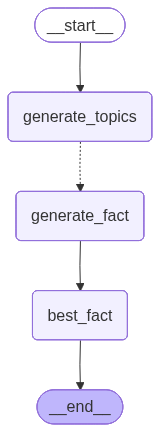

In [11]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_fact", generate_fact)
graph.add_node("best_fact", best_fact)

graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_facts, ["generate_fact"])
graph.add_edge("generate_fact", "best_fact")
graph.add_edge("best_fact", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [12]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "bollywood songs"}):
    print(s)

{'generate_topics': {'subjects': ['Evolution of Bollywood Music: From Classical to Contemporary', 'Influence of Bollywood Songs on Global Music Trends', 'Iconic Bollywood Playback Singers and Their Contributions', 'The Role of Bollywood Songs in Indian Cinema Storytelling', 'Cultural Significance of Bollywood Songs in Indian Festivals and Celebrations']}}
{'generate_fact': {'facts': ['Lata Mangeshkar, often referred to as the "Nightingale of India," holds the Guinness World Record for the most recorded artist in music history. Over her illustrious career spanning seven decades, she lent her voice to over 30,000 songs in more than 36 languages, making her an iconic figure in Bollywood and a symbol of India\'s rich musical heritage. Her contributions have not only shaped the soundscape of Indian cinema but have also left an indelible mark on the global music industry.']}}
{'generate_fact': {'facts': ['Bollywood songs have significantly influenced global music trends, particularly in the 

## Studio

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

Let's load the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.